In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics
from matplotlib.pylab import rcParams
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, roc_curve, ConfusionMatrixDisplay, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder ,StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

In [3]:
df = pd.read_csv('insurance.csv')

<h2>Exploratory Data Analysis and data preparation<h2/>

We can see that there are 1338 records in the table and there are no nulls in the table. Data seems to be clean.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Mean of charges varies from median which suggests that charges' distribution is not normal. Charges are in general high values - these are annual amounts. When it comes to children and BMI, mean is close to the median. At first sight, we may say that there are no outliers (seeing min and max values).

In [18]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [87]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [19]:
#regions are quite evenly distributed
df['region'].value_counts().to_frame()

,region
southeast,364
southwest,325
northwest,325
northeast,324


In [4]:
#cleaning the index
df.reset_index(inplace=True)
df.set_index('index', inplace=True)

In [5]:
#some columns require transformation in order to be comprehensible by models. 
#There are only two labels in "smoker" and "children" columns, that's why I decided to use the label encoder
labelencoder = LabelEncoder()

In [6]:
df['sex'] = labelencoder.fit_transform(df['sex'])
df['smoker'] = labelencoder.fit_transform(df['smoker'])
#I'm using the pandas get_dummies method which will create a column for each region
df = pd.get_dummies(data=df, columns=['region'])

In [23]:
df

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
index,,,,,,,,,,
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,1,0,0
1334,18,0,31.920,0,0,2205.98080,1,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,0,1,0


Our target variable - charges - has a right-skewed distribution.

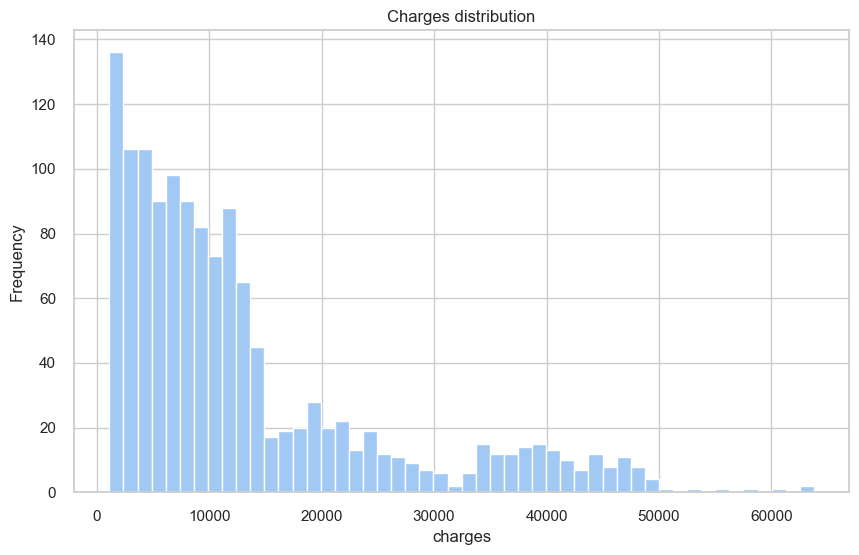

In [13]:
plt.figure(figsize=(10,6))
df['charges'].plot(kind='hist', bins=50)
plt.xlabel('charges')
plt.title('Charges distribution')
plt.show()

I decided to add another column, which would classify BMI values. This is just a transformation for the purpose of EDA and to practice 

In [9]:
bmi = pd.DataFrame(
    [
    {"BMI": "< 18.5", "Condition": "Underweight"},
    {"BMI": "18.5 - 24.9", "Condition": "Healthy weight"},
    {"BMI": "25.0 - 29.9", "Condition": "Overweight"},
    {"BMI": "35 > X > 30", "Condition": "Obesity, class 1"},
    {"BMI": "40 > X > 35", "Condition": "Obesity, class 2"},
    {"BMI": "< 40", "Condition": "Obesity, class 3"}
    ]
)
bmi

,BMI,Condition
0,< 18.5,Underweight
1,18.5 - 24.9,Healthy weight
2,25.0 - 29.9,Overweight
3,35 > X > 30,"Obesity, class 1"
4,40 > X > 35,"Obesity, class 2"
5,< 40,"Obesity, class 3"


In [10]:
conditions = [
    (df['bmi'] >= 0) & (df['bmi'] < 25),
    (df['bmi'] >= 25) & (df['bmi'] < 30),
    (df['bmi'] >= 30) & (df['bmi'] < 35),
    (df['bmi'] >=35) & (df['bmi'] < 40),
    (df['bmi'] >= 40) & (df['bmi'] < 45),
    (df['bmi'] >= 45)
]

results = ['Underweight', 'Healthy weight', 'Overweight', 'Obesity, class 1', 'Obesity, class 2', 'Obesity, class 3']

df['BMI'] = np.select(conditions, results)

We can see that the majority class is "overweight". There are less people with healthy weight. There are almost twice as many people that weigh too much. Our dataset comes from the USA, where obesity is a huge social problem.

In [100]:
df['BMI'].value_counts().to_frame()

,count
BMI,
Overweight,391
Healthy weight,386
Underweight,245
"Obesity, class 1",225
"Obesity, class 2",71
"Obesity, class 3",20


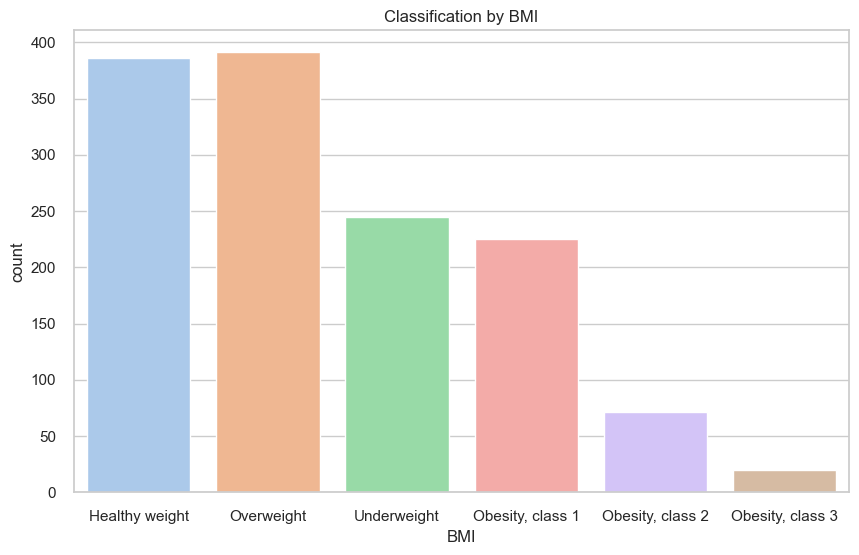

In [12]:
plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid", palette="pastel")
sns.countplot(x=df['BMI'])
plt.title('Classification by BMI')

plt.show();

We can see that the majority of our customers are non-smokers. 

In [27]:
df['smoker'].value_counts().to_frame()

,smoker
0,1064
1,274


In [14]:
nosmoke = df[df['smoker']==0]
smoke = df[df['smoker']==1]

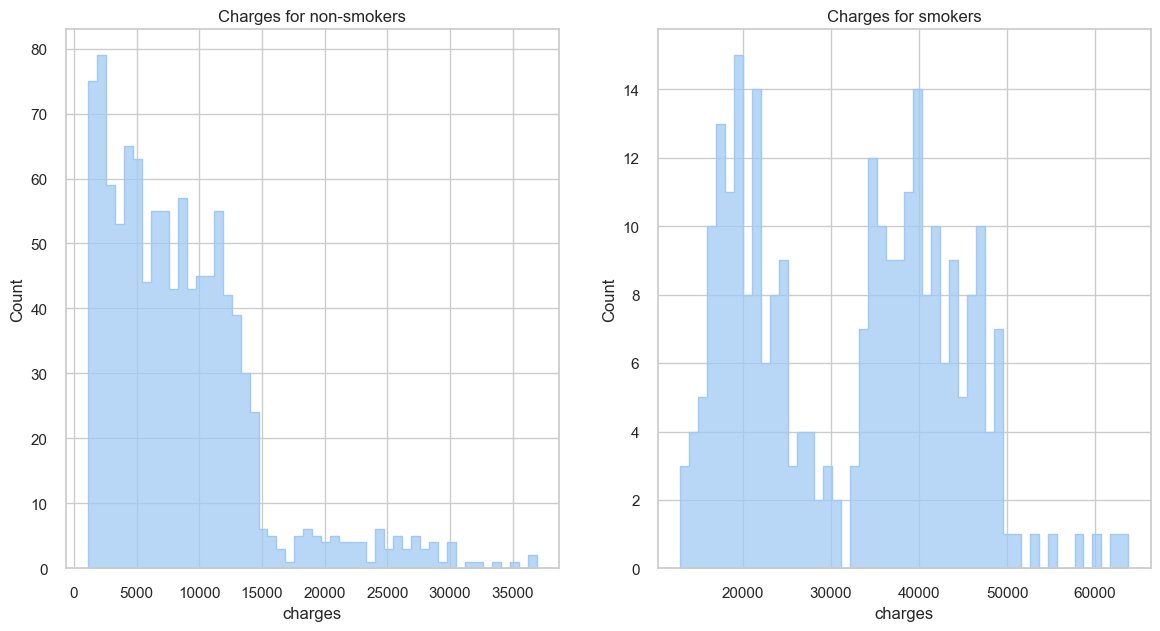

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
sns.histplot(nosmoke['charges'], ax=axes[0], bins=50, element="step")
axes[0].set_title('Charges for non-smokers')
sns.histplot(x='charges', data=smoke, ax=axes[1], bins=50, element="step")
axes[1].set_title('Charges for smokers')
plt.style.use('seaborn-deep')
plt.show()

Charges range for people that smoke is much higher. The distribution is different - for non-smokers the distribution is right-skewed that is a distribution common for financial data (majority of low values). Whereas for smokers, the distribution is irregualar (has almost two peaks). This can of course be caused by the scarcity of data for smokers.


When it comes to sex, there is almost the same number of women and men. 

In [29]:
df['sex'].value_counts().to_frame('Count')

,Count
1,676
0,662


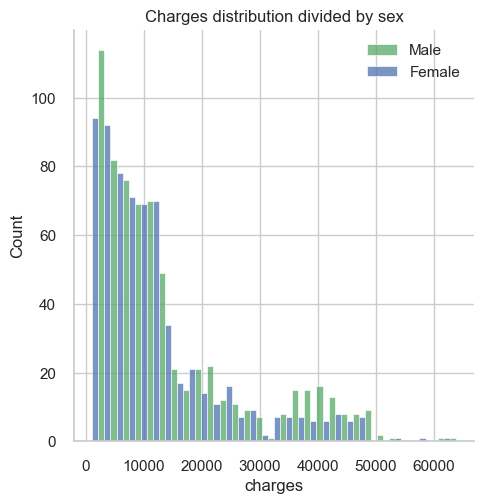

In [21]:
sns.displot(df, x='charges', hue='sex', multiple='dodge', legend=False)
plt.title('Charges distribution divided by sex')
plt.legend(['Male','Female'])
plt.show();

There are no major differences between charges for women and men. We observe a slight difference in the range of ca. 40,000 - there are more men that pay higher charges.

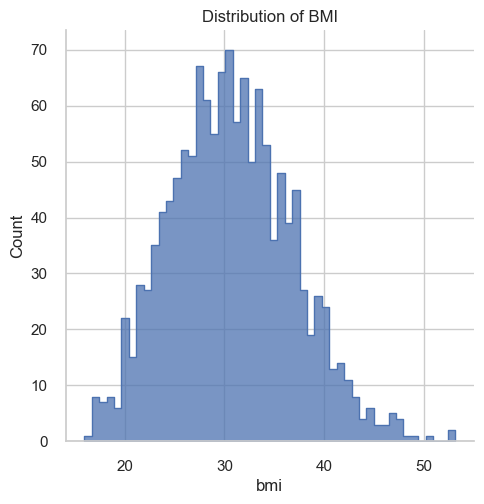

In [22]:
sns.displot(df, x='bmi',element='step', bins=50)
plt.title('Distribution of BMI')
plt.show()

BMI has a normal distribution. The peak is around 30.

In [23]:
df['children'].value_counts().to_frame()

,children
0,574
1,324
2,240
3,157
4,25
5,18


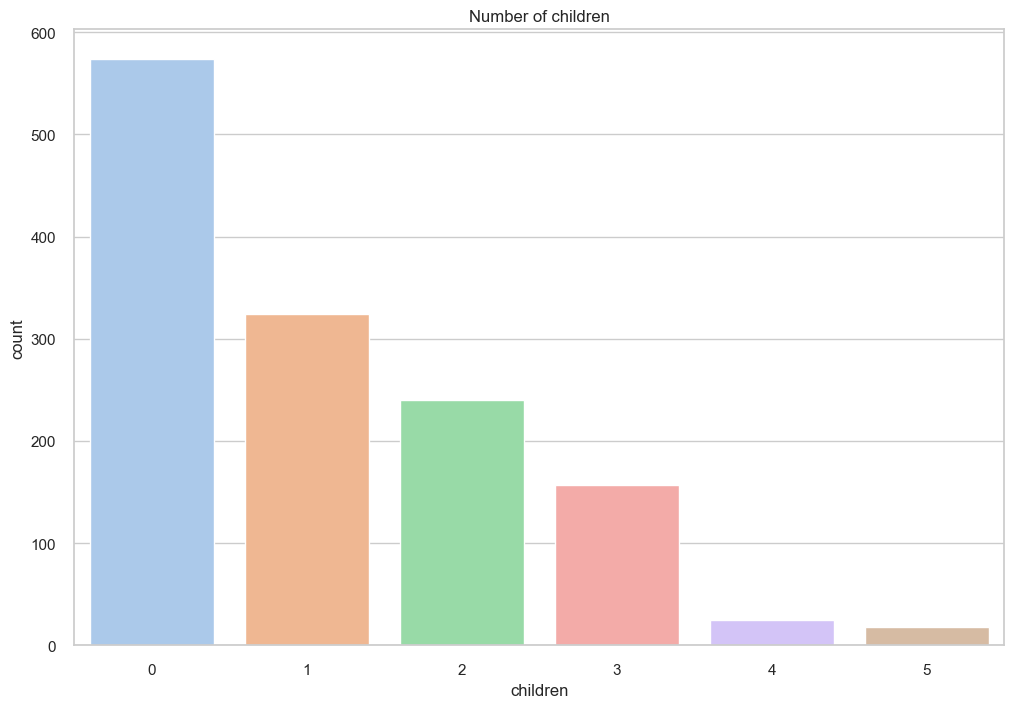

In [24]:
plt.figure(figsize=(12,8))
sns.set_theme(style="whitegrid", palette="pastel")
sns.countplot(x=df['children'])
plt.title('Number of children')

plt.show();

There is a majority of people with no children. There are very few people with 3+ children.

As we can see on the heatmap below, there is no high correlation between variables. The correlation is highest between age, bmi and charges. There is also slight correlation between region southeast and bmi. 

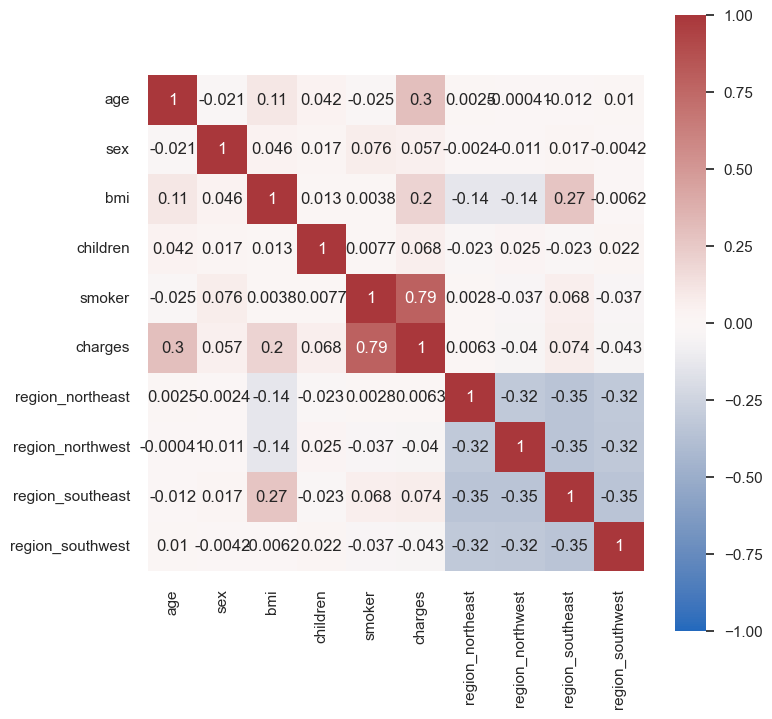

In [25]:
Pearson_correlation_matrix = df.corr(method='pearson')

sns.set(rc={'figure.figsize':(8,8)}) 

sns.heatmap(
    Pearson_correlation_matrix,
    cmap='vlag',
    vmin=-1.,
    vmax=1., 
    square=True,
    annot=True
    ) 

pass

We decided to check Spearman correlation (which determines non-linear relationship between variables), because some of the variables are logical. We may observe that correlation between charges and age is higher here.

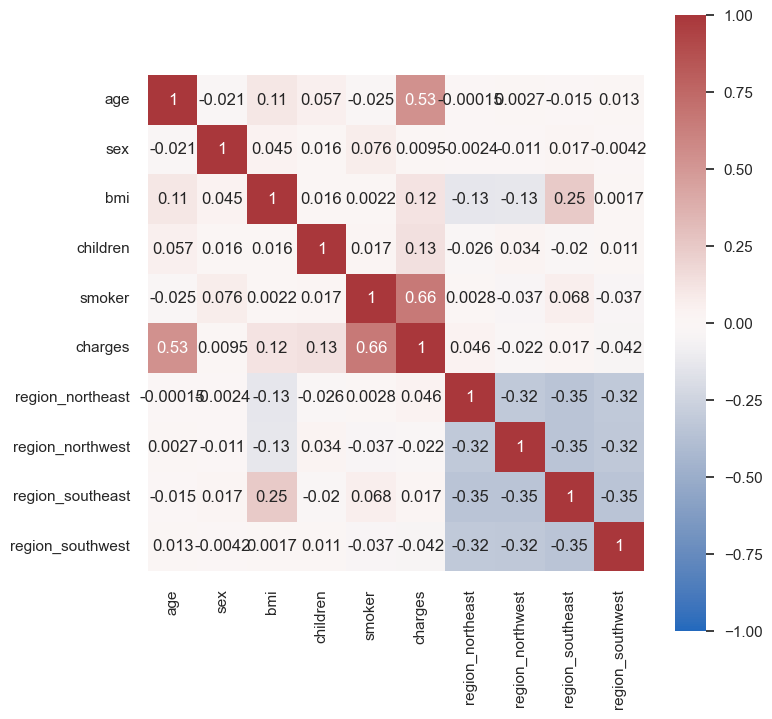

In [26]:
Spearman_correlation_matrix = df.corr(method='spearman')

sns.set(rc={'figure.figsize':(8,8)}) 

sns.heatmap(
    Spearman_correlation_matrix,
    cmap='vlag',
    vmin=-1.,
    vmax=1., 
    square=True,
    annot=True
    ) 

pass

<h2>Modelling<h2/>

<h3>xgboost<h3/>

First I decided to check how will the XGBoost model perform with our data. XGBoost is often referred to as "state-of-the-art" for tabular data.

In [27]:
y = df['charges']
colx = ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
x = df[colx]

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [29]:
xg_reg = xgb.XGBRegressor(
    random_state=0
)

In [30]:
params= {
'n_estimators': range(1,50,5),
'max_depth': range(1,8,2),
'subsample': [0, 0.1, 0.25,0.5, 0.75, 1],
'colsample_bytree': [0, 0.1, 0.25,0.5, 0.75, 1],
'eta': [0, 0.1, 0.25,0.5, 0.75, 1],
}

Parameters tuning took quite a long time. The model below is fitted with the best params.

In [35]:
xg_search = GridSearchCV(xg_reg, params, cv=5)
xg_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=123, ...),
             param_grid={'colsample_bytree': [0, 0.1, 0.25, 0.5, 0.75, 1],
                         'eta': [0, 0.1, 0.25, 0.5, 0.75, 1],
                         'max_depth': range(1, 8, 2),
                         'n_estimators': range(1, 50, 5),
                         'subsample': [0, 0.1, 0.25, 0.5, 0.75, 1]})

In [36]:
xg_search.best_params_

{'colsample_bytree': 1,
 'eta': 0.1,
 'max_depth': 3,
 'n_estimators': 46,
 'subsample': 0.5}

In [37]:
xg_search.best_score_

0.8479449667518283

In [31]:
xg_reg = xgb.XGBRegressor(
    random_state=0, 
    n_estimators=46, 
    max_depth=3,
    subsample=0.5,
    colsample_bytree=1,
    eta=0.1
)

In [32]:
xg_reg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=46, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [40]:
y_pred = xg_reg.predict(x_test)


In [33]:
xg_reg.score(x_test, y_test) 

0.9017671747348195

In [42]:
xg_reg.score(x_train, y_train)

0.8734640854753442

The model is well balanced, the score on train and test is quite close.

In [43]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
print("RMSE - gbtree: ", rmse)
print("MAE - gbtree: ", mae)

RMSE - gbtree:  3953.705323268809
MAE - gbtree:  2343.811561656425


Our model is mistaken by 2374 dollars on average - but we don't know whether it overestimates or underestimates, as MAE takes the absolute value of error. The mean of charges was over 13000 dollars, so the error is quite low.  
When it comes to RMSE, it should also be on the same scale as our target-variable, but it has a tendence to give high weight to large errors - it is more useful when large errors are particularly undesirable. 


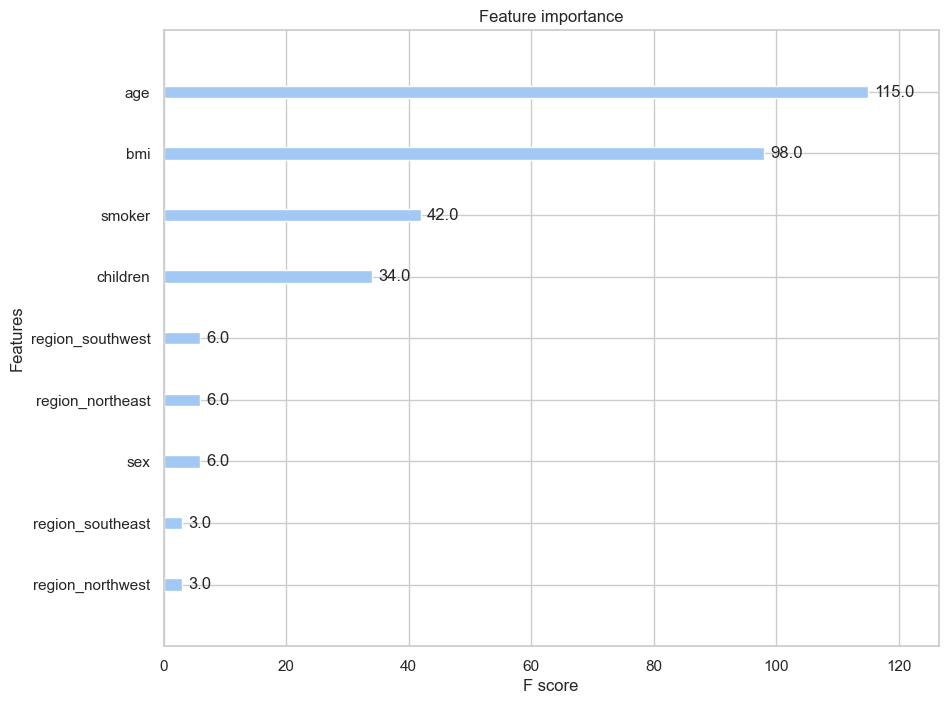

In [45]:
rcParams['figure.figsize'] = 10, 8

xgb.plot_importance(xg_reg);

What is interesting, the most important variable for the model came out to be age, which has in fact correlated with charges, but not as strong as smoking which is on the third place.


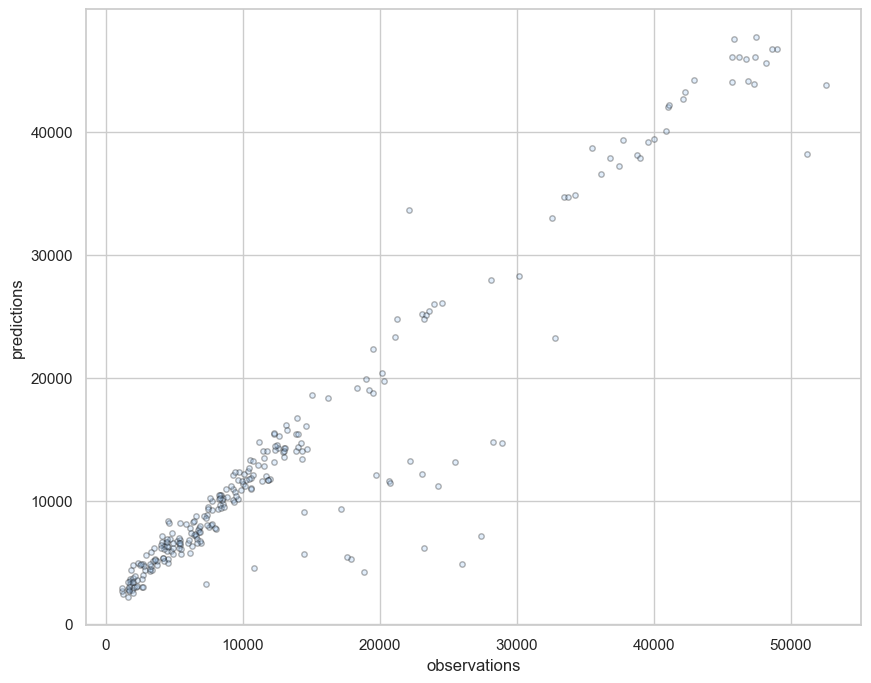

In [47]:
plt.scatter(
    y_test,
    y_pred,
    edgecolor="black",
    s=15, 
    alpha = 0.3)
plt.xlabel("observations")
plt.ylabel("predictions");

In the ideal situation, the observations and predictions would be on one line, but we can see that the deviation is not high.


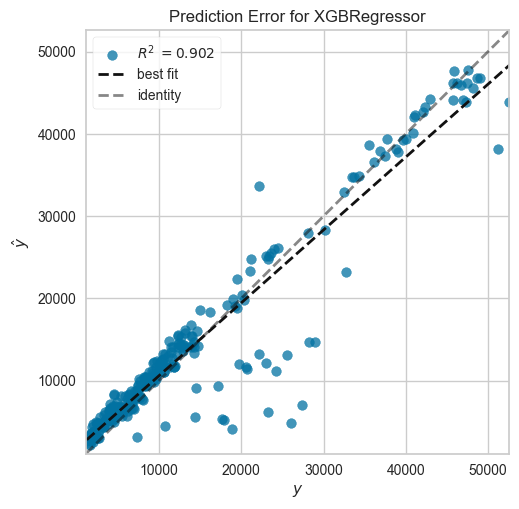

In [50]:
prediction_error(xg_reg, x_train, y_train, x_test, y_test);

R^2 equals to 0.902, which means that the model includes over 90% of variance for our dataset. Our model is quite close to the black "best fit" model, which suggests that it adapts quite well to the most predictions. 

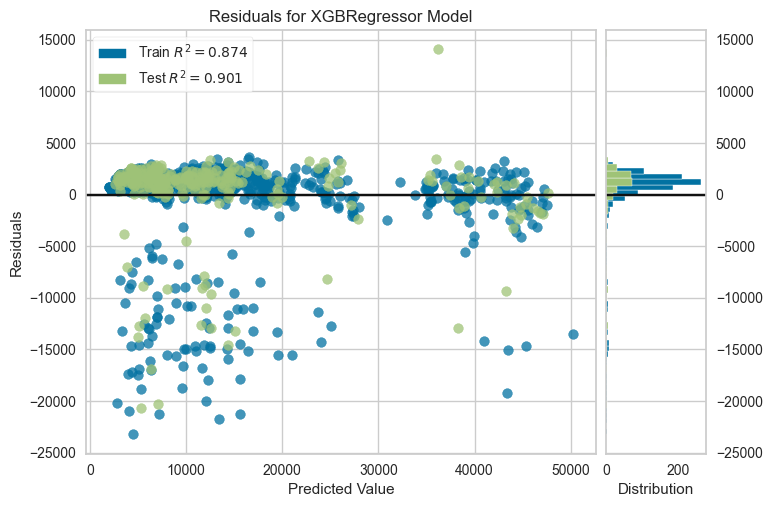

In [142]:
residuals_plot(xg_reg, x_train, y_train, x_test, y_test);

The distribution of residuals is normal. Most residuals are centered on the line. There is a majority of negative residuals - it means that the predicted values are too high. 

<h2>Other models<h2/>

We decided to check how other models perform - we chose Random Forest, Linear Regression and Decision Tree. 

In [39]:
def find_best_models_gridsearchcv(x_train,y_train): 
    algos = {

        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
               
                'splitter': ['best','random'],
                'max_depth': range(4,10),
                'min_samples_leaf':range(1,4)
            }
            
        },
        'randomforest_regressor':{
            'model':RandomForestRegressor(),
            'params':{
                'n_estimators':range(100, 1000, 100),
                'max_depth': range(70,110,10),
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 10]
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x_train,y_train)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    pd.set_option('display.max_colwidth', None) 
    return pd.DataFrame(scores, columns=['model','best_score','best_params'])

find_best_models_gridsearchcv(x_train, y_train)

,model,best_score,best_params
0,decision_tree,0.847743,"{'max_depth': 4, 'min_samples_leaf': 2, 'splitter': 'best'}"
1,randomforest_regressor,0.853975,"{'max_depth': 100, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}"


The score is a bit lower than XGBoosts.

In [47]:
rf=RandomForestRegressor(n_estimators=300, max_depth=100, min_samples_leaf=4, min_samples_split=10)
rf.fit(x_train, y_train)
rf_scores = cross_val_score(rf, x_train, y_train, scoring='r2', cv = 5)
print("Accuracy score for Random forest: ", rf_scores)
print("Average accuracy score for Random forest: ", rf_scores.mean())

Accuracy score for Random forest:  [0.87102642 0.84708013 0.82417615 0.86209979 0.79613256]
Average accuracy score for Random forest:  0.8401030120046459


In [41]:
y_pred = rf.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) Score:', r2)

Root Mean Squared Error (RMSE): 4043.372452610261
Mean Absolute Error (MAE): 2432.8502565276567
R-squared (R2) Score: 0.8972609522936187


Metrics are quite close to those of XGBoost. We'll compare them later on.

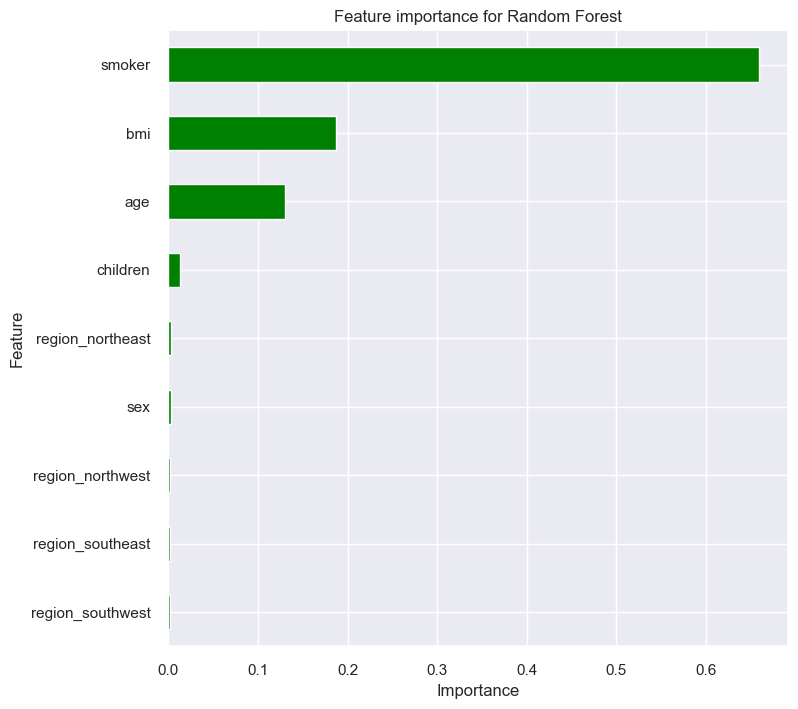

In [49]:
importances = pd.Series(rf.feature_importances_, index = x_train.columns)
importances.sort_values(ascending=True, inplace=True)
importances.plot.barh(color='green')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance for Random Forest')
plt.show()

When it comes to feature importance for Random Forest, the most important is whether the person is smoking, and after that: bmi and age. Other features seem to be almost irrelevant.

And what about a Decision Tree?

In [44]:
dt = DecisionTreeRegressor(splitter='best', max_depth=4, min_samples_leaf=2)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) Score:', r2)

Root Mean Squared Error (RMSE): 4262.62700061735
Mean Absolute Error (MAE): 2574.9733283018045
R-squared (R2) Score: 0.8858166703413736


And how does a linear regression, which is a very simple parametric model, perform with our dataset?

In [45]:
lr = LinearRegression()
lr.fit(x_train, y_train)
lr.score(x_test,y_test)

0.7999876970680433

In [46]:
y_pred = lr.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) Score:', r2)

Root Mean Squared Error (RMSE): 5641.62655885019
Mean Absolute Error (MAE): 3933.272649405234
R-squared (R2) Score: 0.7999876970680433


<h2>Conclusion<h2/>

In [48]:
metrics = pd.DataFrame({'Metrics':['RMSE','MAE', 'R^2'],
                         'Random forest': [4043.37, 2432.85, 0.897],
                         'XGBoost': [3953.71, 2343.81, 0.902],
                         'Linear Regression': [5641.63, 3933.27, 0.799],
                         'Decision Tree': [4262.63, 2574.97, 0.886]})
metrics

,Metrics,Random forest,XGBoost,Linear Regression,Decision Tree
0,RMSE,4043.370,3953.710,5641.630,4262.630
1,MAE,2432.850,2343.810,3933.270,2574.970
2,R^2,0.897,0.902,0.799,0.886


We see that XGBoost model has the highest R^2, that is the percent of correct predictions. However, the difference between XGBoost and other tree models is not big. Also when it comes to RMSE and MAE, the difference is by less than 100 (comparing to Random Forest). Choosing the right model would depend on whether we want a model that is very easy to interpret (then it would be worth to consider Decision Tree) or whether we want to minimize the error - then the XGBoost would be the best choice. Let us not forget that a mistake by a 100, let's say euros, doesn't seem to be a lot, but when we consider the fact that it could concern 1000 customers, then it would be a real loss for the company.   

What's quite interesting is that feature importance was very different for our two ensemle models - XGBoost and Random Forest. For XGBoost it was age -> bmi -> smoker -> children that were important (in that order). Whereas for Random Forest it was smoking -> bmi -> age. 